In [243]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

In [244]:
ROOT_ABSPATH = Path("create_plots.ipynb").resolve().parent.parent
T1_LAYERS_METRICS = ROOT_ABSPATH / "data/metrics/t1_accuracy/layers"
T5_LAYERS_METRICS = ROOT_ABSPATH / "data/metrics/t5_accuracy/layers"
T1_TIMESTEPS_METRICS = ROOT_ABSPATH / "data/metrics/t1_accuracy/timesteps"
T5_TIMESTEPS_METRICS = ROOT_ABSPATH / "data/metrics/t5_accuracy/timesteps"
PLOTS_DIR = ROOT_ABSPATH / "data/plots"

T1_LAYERS_METRICS.mkdir(parents=True, exist_ok=True)
T5_LAYERS_METRICS.mkdir(parents=True, exist_ok=True)
T1_TIMESTEPS_METRICS.mkdir(parents=True, exist_ok=True)
T5_TIMESTEPS_METRICS.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [245]:
def transform_and_extract_metadata(df):
    """
    Reshape a DataFrame by extracting metadata from column names.

    :param df: DataFrame with columns in the format `<model_name>_<layer_idx>_<timestep>_<metric>__*`.
    :return: DataFrame with columns: `value`, `model_name`, `layer_idx`, `timestep`, and `metric`.
    """
    transformed_data = []
    
    for col in df.columns:
        match = re.search(r"(.+?)_(\d+)_(\d+(?:\.\d+)?)[^a-zA-Z]*(.+)__.*", col)
        if match:
            model_name, layer_idx, timestep, metric = match.groups()
            if model_name == "t2i_uncond":
                model_name = "t2i empty caption"
            # Create a DataFrame for each matching column
            transformed_data.append(pd.DataFrame({
                "value": df[col],
                "model_name": model_name,
                "layer_idx": int(layer_idx),
                "timestep": float(timestep),
                "metric": metric,
            }))
    
    # Concatenate all transformsed DataFrames
    result = pd.concat(transformed_data, ignore_index=True)
    return result

In [246]:
def concat_dfs(dir: Path):
    """
    Concatenate and transform all DataFrames in a directory.

    :param dir: Directory containing CSV files.
    :return: A single concatenated DataFrame with transformed and deduplicated data.
    """
    transformed_dfs = []
    for f in dir.iterdir():
        if f.name != ".DS_Store":
            df = pd.read_csv(f)
            transformed_df = transform_and_extract_metadata(df).drop_duplicates()
            transformed_dfs.append(transformed_df)
    return pd.concat(transformed_dfs).reset_index(drop=True)

In [247]:
t1_layers_df = concat_dfs(T1_LAYERS_METRICS)
t5_layers_df = concat_dfs(T5_LAYERS_METRICS)
layers_df = pd.concat([t1_layers_df, t5_layers_df])

t1_ts_df = concat_dfs(T1_TIMESTEPS_METRICS)
t5_ts_df = concat_dfs(T5_TIMESTEPS_METRICS)
ts_df = pd.concat([t1_ts_df, t5_ts_df])

In [248]:
uncond_df = ts_df.loc[(ts_df["model_name"] == "uncond") | (ts_df["model_name"] == "t2i empty caption")].reset_index(drop=True)
t2i_df = ts_df.loc[ts_df["model_name"] == "t2i"].reset_index(drop=True)
unclip_df = ts_df.loc[ts_df["model_name"] == "unclip"].reset_index(drop=True)

In [249]:
def plot_accuracy(df, x_axis='layer', upperbound=None):
    """
    Plot accuracy (Top-1 & Top-5) against layer index or timestep with models sharing colors.

    :param df: 
        A DataFrame containing the data to plot. It must include columns like 'value', 
        'layer_idx', 'timestep', and optionally 'metric' and 'model_name'.
    :param x_axis: 
        Specifies the x-axis variable. Use 'layer' for plotting against `layer_idx`, 
        or 'timestep' for plotting against `timestep`.
    :param upperbound: 
        An optional tuple (top1_upper, top5_upper). If provided, two red dashed lines are drawn:
        - A red dashed line for Top-1 accuracy.
        - A faded red dashed line for Top-5 accuracy.
    """
    if x_axis == 'layer':
        x_col = 'layer_idx'
        xticks = sorted(df['layer_idx'].unique())
    elif x_axis == 'timestep':
        x_col = 'timestep'
        xticks = np.arange(0, 1.0625, 0.0625)
        df['legend_label'] = df['model_name'] + " (Layer " + df['layer_idx'].astype(str) + ")"
    else:
        raise ValueError("x_axis must be either 'layer' or 'timestep'")

    # Ensure metric column formatting
    df['metric'] = df['metric'].astype(str)

    # Extract and format metric names for title & legend
    metric_names = sorted(set(df["metric"].str.replace("full_", "").str.replace("_", " ").str.title()))
    formatted_metrics = " & ".join(metric_names)

    # Assign unique colors per model
    unique_models = df['model_name'].unique()
    palette = sns.color_palette("tab10", len(unique_models))
    model_color_map = {model: color for model, color in zip(unique_models, palette)}

    # Define line styles and alpha (transparency) levels for different metrics
    style_map = {
        'full_top1_accuracy': {'linestyle': '-', 'alpha': 1.0},
        'full_top5_accuracy': {'linestyle': '--', 'alpha': 0.4}
    }

    # Plot setup
    plt.figure(figsize=(10, 6))

    # Plot each model-metric combination separately with assigned styles
    for (model, metric), sub_df in df.groupby(['model_name', 'metric']):
        style = style_map.get(metric, {'linestyle': '-', 'alpha': 1.0})
        color = model_color_map[model]
        formatted_metric = metric.replace("full_", "").replace("_", " ").title()
        label = f"{model} - {formatted_metric}"
        
        sns.lineplot(
            data=sub_df, 
            x=x_col, 
            y='value', 
            label=label, 
            marker='o',
            linestyle=style['linestyle'], 
            color=color,
            alpha=style['alpha']
        )

    # Add upperbound lines if applicable
    if upperbound is not None:
        top1_upper, top5_upper = upperbound
        
        if top1_upper is not None:
            plt.axhline(y=top1_upper, color='red', linestyle='--', linewidth=1.5, alpha=1.0, label=f'CLIP encoder (Top-1: {top1_upper * 100:.0f}%)')

        if top5_upper is not None:
            plt.axhline(y=top5_upper, color='red', linestyle='--', linewidth=1.5, alpha=0.4, label=f'CLIP encoder (Top-5: {top5_upper * 100:.0f}%)')

    # Adjust Y-axis limits
    y_min, y_max = plt.ylim()
    max_upperbound = max([v for v in upperbound if v is not None]) if upperbound else y_max
    plt.ylim(0, max(y_max, max_upperbound))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y * 100:.0f}"))

    # Title, labels, and legend
    x_label = " ".join(x_col.split("_")).capitalize()
    models = "_".join(list(df['model_name'].unique()))

    plt.title(f"{formatted_metrics} vs. {x_label}", fontsize=16)
    plt.xlabel(x_label, fontsize=14, labelpad=15)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.xticks(xticks, [f"{str(tick)[:4]}" for tick in xticks], fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title=f"Model & Metric", fontsize=9, title_fontsize=10, loc='best')
    # plt.legend(title=f"Model & Metric", fontsize=8, title_fontsize=10, markerscale=0.8)
    plt.grid(True)

    # Save the plot
    plt.tight_layout()
    fname = f"{x_label}_vs_{formatted_metrics}_on_{models}".lower().replace(" ", "_")
    plt.savefig(PLOTS_DIR / f"{fname}.png")
    plt.show()


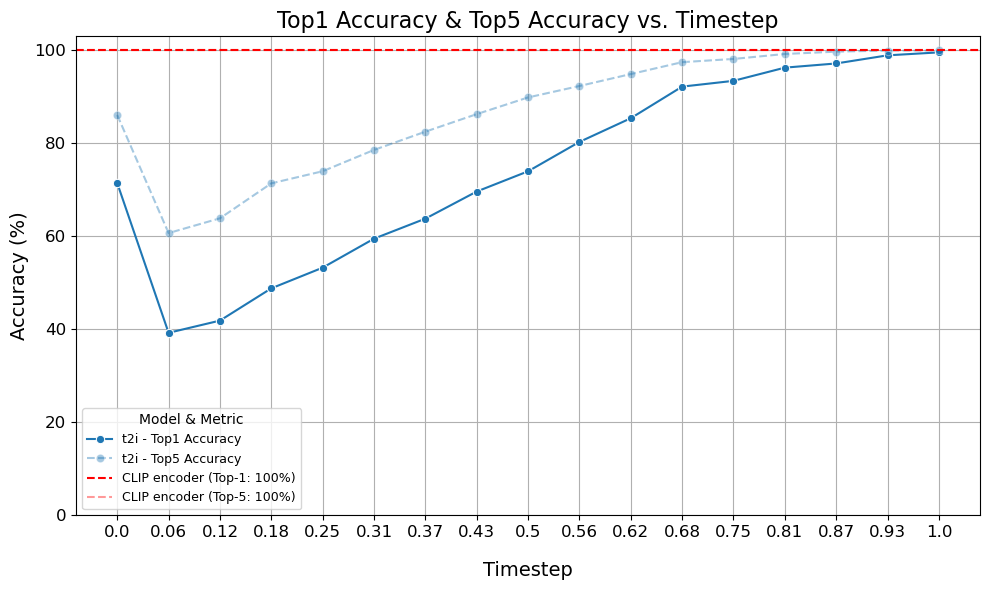

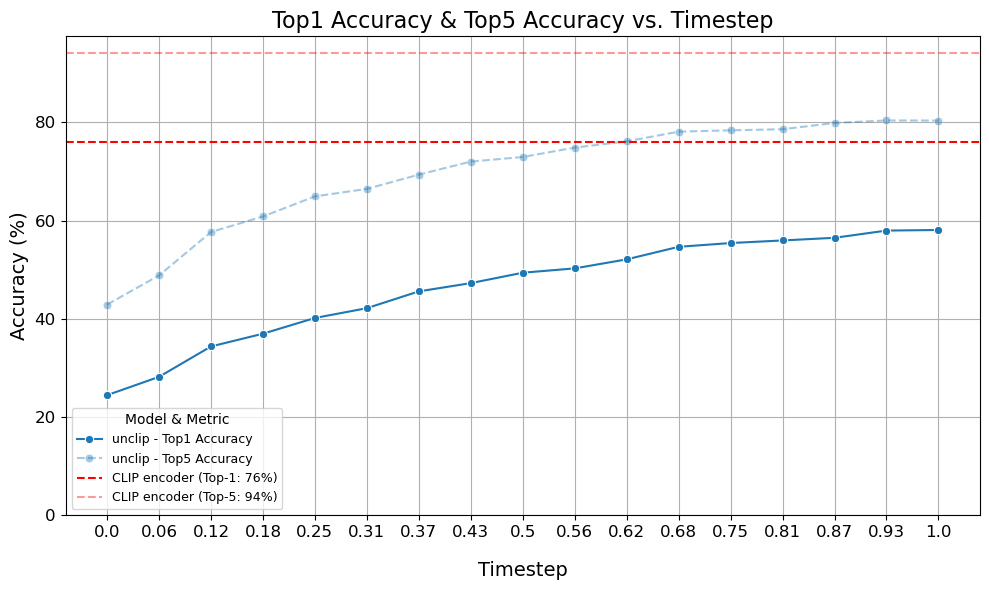

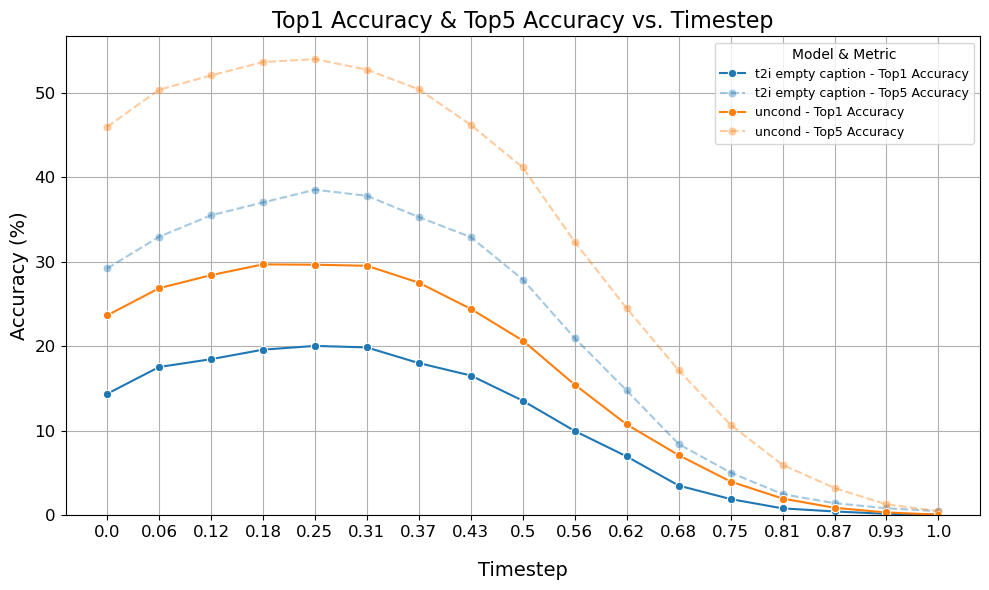

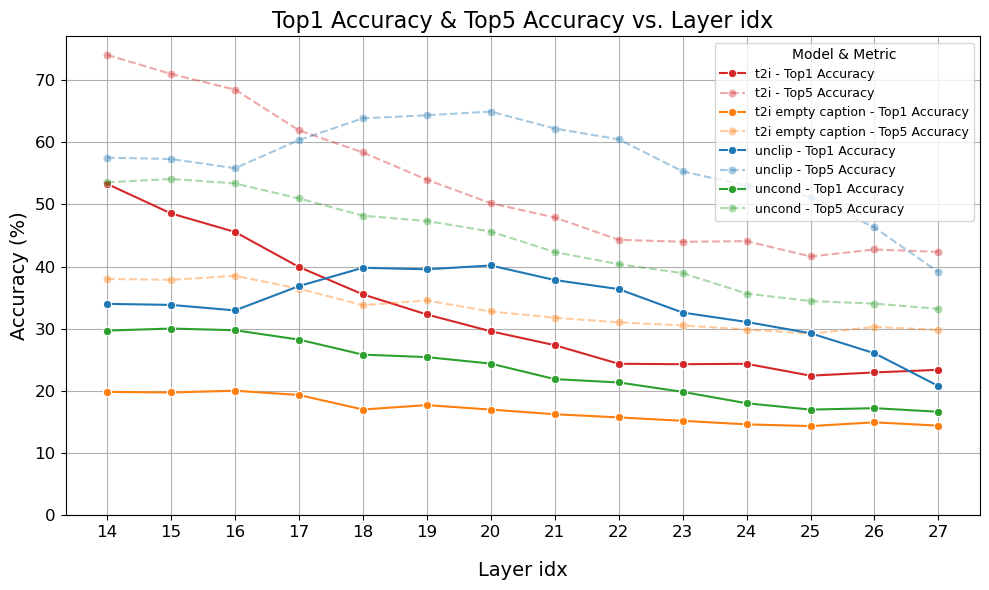

In [250]:
plot_accuracy(t2i_df, x_axis="timestep", upperbound=(1, 1))
plot_accuracy(unclip_df, x_axis="timestep", upperbound=(0.76, 0.94))
plot_accuracy(uncond_df, x_axis="timestep")
plot_accuracy(layers_df)